# Lottery Draw Analysis and Pattern Prediction

> **Important**: For reproducibility, please:
> 1. Restart the kernel (Runtime > Restart kernel)
> 2. Run all cells in order (Runtime > Run all)
> 3. Wait for each cell to complete before proceeding

This notebook analyzes lottery draw data to identify patterns and predict potential future draws. It includes:
- Automated data downloading and preparation
- Pattern analysis with visualizations
- Machine learning-based pattern prediction

In [198]:
# Install required packages
%pip install -q pandas seaborn matplotlib requests joblib scikit-learn tqdm

# Required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from tqdm.notebook import tqdm  # For progress bars in loops
import requests
import zipfile
import os
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Setup
The next cell will install required packages and set up the environment. Choose your environment:
- 'fdj': French National Lottery (full dataset)
- 'em': EuroMillions (full dataset)

In [250]:
# ENVIRONMENTS SETUP
ENVIRONMENTS = {
    "fdj": {  # French National Lottery
        "url_to_zip": "https://www.sto.api.fdj.fr/anonymous/service-draw-info/v3/documentations/1a2b3c4d-9876-4562-b3fc-2c963f66afp6",
        "file_name": "loto_201911.csv",
        "max_number": 49,
    },
    "em": {  # EuroMillions
        "url_to_zip": "https://media.fdj.fr/static-draws/csv/euromillions/euromillions_202002.zip", # https://www.sto.api.fdj.fr/anonymous/service-draw-info/v3/documentations/1a2b3c4d-9876-4562-b3fc-2c963f66afe6
        "file_name": "euromillions_202002.csv",
        "max_number": 50,
    },

}

# Select environment (change this to switch between environments)
ENV = "fdj"  # Options: "fdj", "em"
config = ENVIRONMENTS[ENV]

# Extract configuration
url_to_zip = config["url_to_zip"]
file_name = config["file_name"]
max_number = config["max_number"]

print(f"Selected environment: {ENV}")
print(f"Using file: {file_name}")
print(f"Maximum number: {max_number}")

Selected environment: fdj
Using file: loto_201911.csv
Maximum number: 49


## Data Loading and Processing

This section:
1. Downloads the lottery data ZIP file from the configured URL
2. Extracts the CSV file
3. Loads the data into a pandas DataFrame
4. Processes the relevant columns (boule_1 through boule_5, numero_chance if available)

The data processing is configured based on the selected environment (FDJ or EuroMillions).

In [251]:
def download_and_extract_zip(url, destination_folder):
    """
    Downloads a zip file from the given URL and extracts its contents.
    
    Args:
        url (str): URL of the zip file to download
        destination_folder (str): Where to extract the contents
        
    Returns:
        bool: True if successful, False otherwise
    """
    print(f"Downloading from {url}...")
    try:
        response = requests.get(url, timeout=30)
        
        if response.status_code == 404:
            print("❌ File not found (404)")
            return False
        elif response.status_code == 200:
            zip_filename = "downloaded_file.zip"
            with open(zip_filename, 'wb') as f:
                f.write(response.content)

            print("Extracting files...")
            with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
                zip_ref.extractall(destination_folder)

            os.remove(zip_filename)
            print(f"✓ Successfully downloaded and extracted to {destination_folder}")
            return True
        else:
            print(f"❌ Failed to download. Status code: {response.status_code}")
            return False
            
    except Exception as e:
        print(f"❌ Error: {str(e)}")
        return False

# Download the lottery data
if download_and_extract_zip(url_to_zip, "./"):
    print("✓ Data ready for processing")
else:
    print("❌ Failed to prepare data")

Extracting files...
✓ Successfully downloaded and extracted to ./
✓ Data ready for processing


In [258]:
# Create a DataFrame with all possible numbers from 1 to 49 inclusive
all_numbers = pd.DataFrame({'number': range(1, max_number + 1)})

try:
    df = pd.read_csv(file_name, sep=";", encoding="utf-8")
except UnicodeDecodeError:
    # Try with a common alternative encoding for French/Euro files
    df = pd.read_csv(file_name, sep=";", encoding="latin1")

if ENV == "fdj":
    df = df[['boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5', 'numero_chance', 'date_de_tirage']]
else:
    df = df[['boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5', 'date_de_tirage']]

df.head(20)

,boule_1,boule_2,boule_3,boule_4,boule_5,numero_chance,date_de_tirage
0,32,26,2,5,44,10,25/06/2025
1,20,42,38,44,25,10,23/06/2025
2,34,25,49,18,20,2,21/06/2025
3,9,36,13,24,19,3,18/06/2025
4,1,2,13,39,4,1,16/06/2025
5,25,21,31,44,16,8,14/06/2025
6,9,19,7,18,15,6,11/06/2025
7,25,38,5,34,12,10,09/06/2025
8,7,30,40,37,45,1,07/06/2025
9,2,45,41,18,38,8,04/06/2025


In [261]:
# Pattern Analysis

print("Analyzing patterns...")

# Select boule columns that exist in the DataFrame
boule_cols = ['boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5']
existing_boule_cols = [col for col in boule_cols if col in df.columns]

if not existing_boule_cols:
    print("Error: None of the boule columns are present in the DataFrame. Pattern analysis cannot proceed.")
else:
    # Convert to numpy array for faster processing
    numbers = np.asarray(df[existing_boule_cols])

    # Sort each row
    numbers.sort(axis=1)

    # Create a DataFrame with sorted numbers
    sorted_df = pd.DataFrame(numbers, columns=pd.Index(existing_boule_cols), index=df.index)

    # Function to convert number to color
    def get_color(x):
        if pd.isna(x):
            return 'unknown'
        x = int(x)
        if x <= 10:
            return 'green'
        elif x <= 20:
            return 'yellow'
        elif x <= 30:
            return 'red'
        elif x <= 40:
            return 'purple'
        else:
            return 'blue'

    print("Categorizing numbers...")
    # Convert numbers to colors
    colors = np.vectorize(get_color)(numbers)
    categorized_df = pd.DataFrame(colors, columns=pd.Index(existing_boule_cols), index=df.index)

    # Create patterns
    print("Creating patterns...")
    # tqdm causes ImportError: IProgress not found in some Jupyter environments.
    # We'll use a simple for loop instead.

    patterns = []
    print("Creating patterns (no progress bar)...")
    for row in colors:
        patterns.append('-'.join(row))
    categorized_df['Pattern'] = patterns

    # Get statistics
    print("Analyzing frequencies...")
    pattern_counts = pd.Series(patterns).value_counts()

    print("\nMost common patterns:")
    display(pattern_counts.head(10))

    print(f"Total draws: {colors.shape[0]}")

Analyzing patterns...
Categorizing numbers...
Creating patterns...
Creating patterns (no progress bar)...
Analyzing frequencies...

Most common patterns:


green-yellow-red-purple-blue      42
green-green-yellow-purple-blue    28
green-green-yellow-red-blue       24
green-yellow-yellow-red-blue      22
green-yellow-purple-blue-blue     22
green-yellow-yellow-red-purple    21
green-green-yellow-red-purple     21
yellow-red-purple-purple-blue     21
green-red-red-purple-purple       20
green-yellow-red-red-blue         20
Name: count, dtype: int64

Total draws: 883


## Heatmap Visualization

The heatmap shows the frequency of each number's appearance in the lottery draws:
- X-axis: Numbers from 1 to max_number
- Color intensity: Higher intensity = more frequent occurrence
- Numbers in cells: Exact count of appearances

We analyze different time ranges to identify both long-term and recent trends:
- Last 5 draws: Very recent patterns
- Last 15 draws: Short-term trends
- Last 50 draws: Medium-term patterns
- All draws: Long-term frequency distribution

This helps identify "hot" (frequently drawn) and "cold" (rarely drawn) numbers over different time periods.

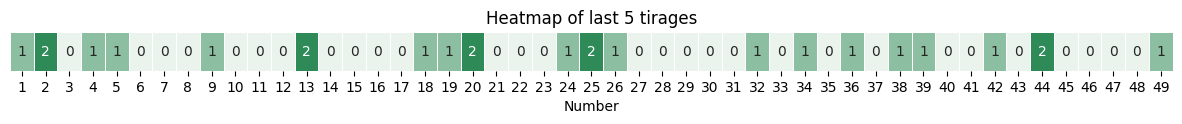

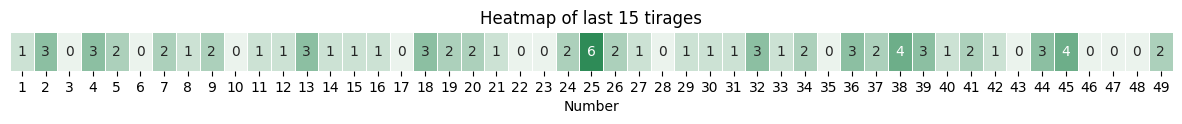

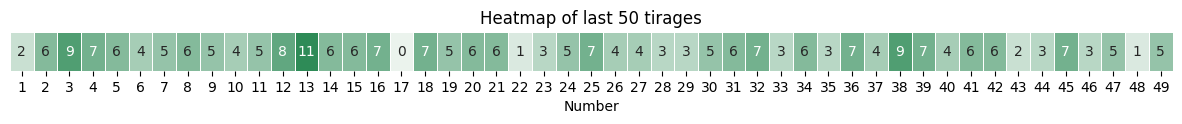

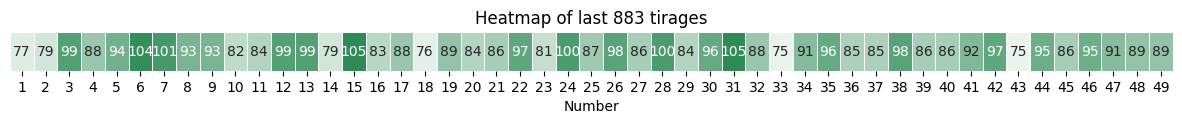

In [254]:
# HEATMAP
def extract_data_frame(data_frame, first_n_rows=None):
    """
    Returns a copy of the first_n_rows of the DataFrame, or the whole DataFrame if first_n_rows is None.
    """
    if first_n_rows is None:
        return data_frame.copy()
    return data_frame.iloc[:first_n_rows].copy()

def show_heat_map(last_tirages=None):
    """
    Displays a heatmap of the frequency of each number (1-max_number) in the last `last_tirages` draws.
    If last_tirages is None, uses all available draws.
    Handles KeyError if boule columns are missing.
    """
    extracted_df = extract_data_frame(df, last_tirages)
    boule_cols = ['boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5']

    # Check if all boule columns exist in the DataFrame
    missing_cols = [col for col in boule_cols if col not in extracted_df.columns]
    if missing_cols:
        print(f"Warning: The following columns are missing in the DataFrame and will be skipped: {missing_cols}")
        boule_cols = [col for col in boule_cols if col in extracted_df.columns]
        if not boule_cols:
            print("Error: No boule columns found in the DataFrame. Cannot plot heatmap.")
            return

    # Only melt if there are valid boule columns
    flat_df = extracted_df.melt(value_vars=boule_cols, var_name='boule', value_name='number')

    tirages_count = len(extracted_df)

    # Count occurrences of each number
    number_counts = flat_df['number'].value_counts().reindex(range(1, max_number+1), fill_value=0).sort_index()

    plt.figure(figsize=(15, 0.5))
    sns.heatmap(
        np.array(number_counts.values).reshape(1, -1),
        cmap=sns.light_palette("seagreen", as_cmap=True),
        annot=True,
        fmt='d',
        linewidths=.5,
        cbar=False,
        xticklabels=[str(x) for x in number_counts.index]
    )
    plt.title(f'Heatmap of last {tirages_count} tirages')
    plt.yticks([])
    plt.xlabel('Number')
    plt.show()

# Example usage
for n in [5, 15, 50, None]:
    show_heat_map(n)

### Pattern Visualization Explanation

The visualizations above show:

1. **Color Legend**: Shows what each color represents in terms of number ranges.
   - Each rectangle represents a range of 10 numbers
   - Colors progress from green (lowest) to blue (highest)

2. **Recent Draw Patterns**: Shows the last 20 draws
   - Each row represents one draw
   - Most recent draws are at the top
   - Each rectangle in a row represents one number's range

3. **Most Common Patterns**: Shows the 10 most frequent patterns
   - Each row is a unique pattern
   - Most frequent patterns are at the top
   - Helps identify common number range distributions

These visualizations help identify trends in how numbers are distributed across ranges in winning draws.

Color Legend for Number Ranges:


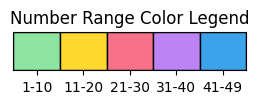


Recent Draw Patterns:


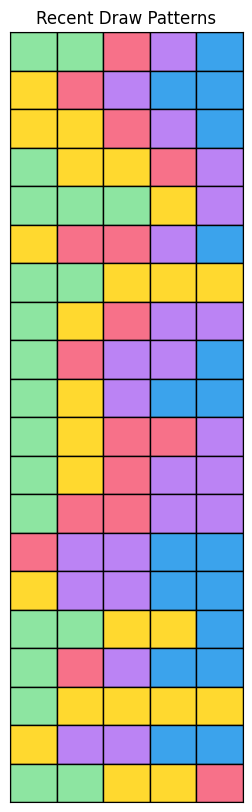


Most Common Patterns:


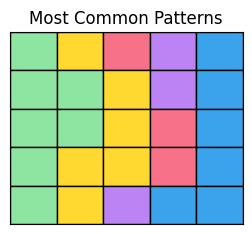

In [255]:
class ColorLegend:
    """
    Creates and displays a color legend for number ranges.
    """
    def __init__(self):
        self.colors = ['#8de5a1', '#ffd92f', '#f77189', '#bb83f4', '#3ba3ec']
        self.ranges = ['1-10', '11-20', '21-30', '31-40', f'41-{max_number}']
        
    def plot(self, figsize=(3, 0.5)):
        """Display the color legend with number ranges."""
        fig, ax = plt.subplots(figsize=figsize)
        
        # Create color rectangles
        for i, (color, label) in enumerate(zip(self.colors, self.ranges)):
            rect = mpatches.Rectangle(
                (i, 0), 1, 1,
                facecolor=color,
                edgecolor='black'
            )
            ax.add_patch(rect)
        
        # Customize plot
        ax.set_xlim(0, len(self.colors))
        ax.set_ylim(0, 1)
        ax.set_xticks([i + 0.5 for i in range(len(self.colors))])
        ax.set_xticklabels(self.ranges)
        ax.set_yticks([])
        plt.title('Number Range Color Legend')
        plt.show()

class PatternPlotter:
    """
    Visualizes lottery draw patterns using color-coded rectangles.
    """
    def __init__(self, patterns, title, max_patterns=20):
        """
        Args:
            patterns (list): List of color patterns (e.g., ['green-yellow-red-purple-blue', ...])
            max_patterns (int): Maximum number of patterns to display
        """
        self.patterns = patterns[:max_patterns]
        self.title = title
        self.colors = {
            'green': '#8de5a1',
            'yellow': '#ffd92f',
            'red': '#f77189',
            'purple': '#bb83f4',
            'blue': '#3ba3ec'
        }
        
    def plot(self, figsize=None):
        """Display the patterns as colored rectangles."""
        n_patterns = len(self.patterns)
        if n_patterns == 0:
            print("No patterns to display.")
            return

        # Set default figsize: height=0.5 (like ColorLegend) if only one pattern, else 0.5 per pattern
        if figsize is None:
            # If only one pattern, use (3, 0.5) like ColorLegend; else, (3, n_patterns*0.5)
            height = max(0.5, n_patterns * 0.5)
            figsize = (3, height)
            
        fig, ax = plt.subplots(figsize=figsize)
        
        # Plot each pattern
        for i, pattern in enumerate(self.patterns):
            colors = pattern.split('-')
            for j, color in enumerate(colors):
                rect = mpatches.Rectangle(
                    (j, n_patterns - i - 1), 1, 1,
                    facecolor=self.colors[color],
                    edgecolor='black'
                )
                ax.add_patch(rect)
        
        # Customize plot
        ax.set_xlim(0, 5)  # 5 numbers per draw
        ax.set_ylim(0, n_patterns)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.title(self.title)
        plt.show()

# Display the legend
print("Color Legend for Number Ranges:")
ColorLegend().plot()

# Display recent patterns
print("\nRecent Draw Patterns:")
recent_patterns = categorized_df['Pattern'].head(20).tolist()
# Use same height as ColorLegend (0.5) for each pattern
PatternPlotter(recent_patterns, title='Recent Draw Patterns').plot(figsize=(3, len(recent_patterns)*0.5))

# Display most common patterns
print("\nMost Common Patterns:")
common_patterns = pattern_counts.head(5).index.tolist()
# Use same height as ColorLegend (0.5) for each pattern
PatternPlotter(common_patterns, title='Most Common Patterns').plot(figsize=(3, len(common_patterns)*0.5))


## Machine Learning Pattern Prediction

This section uses a Decision Tree Classifier to predict potential future patterns based on historical data. The process:

1. **Data Preparation**
   - Convert color patterns to numerical values
   - Create features from historical patterns
   - Split data into training and test sets

2. **Model Training**
   - Train a Decision Tree Classifier
   - Evaluate accuracy on test data
   - Save model for future use

3. **Prediction**
   - Use the trained model to predict the next likely pattern
   - Visualize the predicted pattern

Note: This is for analysis purposes only. Past patterns do not guarantee future results.

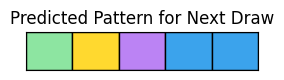

In [256]:
# These imports are specific to the machine learning section and are best kept here, 
# close to where they are used for clarity and modularity.
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import joblib   

# Map color names to integer codes for model input
COLOR_MAPPING = {'green': 0, 'yellow': 1, 'red': 2, 'purple': 3, 'blue': 4}
REVERSE_COLOR_MAPPING = {v: k for k, v in COLOR_MAPPING.items()}

def encode_pattern(pattern_str, color_mapping):
    """Convert a pattern string to a list of integer codes."""
    return [color_mapping[color] for color in pattern_str.split('-')]

def decode_pattern(encoded_pattern, reverse_mapping):
    """Convert a list of integer codes back to a pattern string."""
    return '-'.join([reverse_mapping[int(x)] for x in encoded_pattern])

# Prepare DataFrame from categorized patterns
data = {
    'Pattern': categorized_df['Pattern']
}
df = pd.DataFrame(data)

# Encode patterns as lists of integers
df['PatternEncoded'] = df['Pattern'].apply(lambda x: encode_pattern(x, COLOR_MAPPING))

# Prepare features (X) and targets (y) for supervised learning
# X: all but last pattern, y: next pattern (shifted up by 1)
X = df['PatternEncoded'].iloc[:-1].tolist()
y = df['PatternEncoded'].shift(-1).dropna().tolist()

# Split into training and test sets for evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Decision Tree Classifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Save the trained model for future use
joblib.dump(clf, 'pattern-oracle.joblib')
# To load: clf = joblib.load('pattern-oracle.joblib')

# Evaluate model on test set
y_pred_test = clf.predict(X_test)

# Flatten lists for accuracy calculation
y_pred_test_flat = [item for sublist in y_pred_test for item in sublist]
y_test_flat = [item for sublist in y_test for item in sublist]

accuracy = accuracy_score(y_test_flat, y_pred_test_flat)
# print(f'Test Set Accuracy: {accuracy:.4f}')  # Suppressed as per instruction

# Predict the next pattern based on the most recent pattern
first_row_features = np.array(df['PatternEncoded'].iloc[0]).reshape(1, -1)
predicted_pattern = clf.predict(first_row_features)[0]
predicted_pattern_str = decode_pattern(predicted_pattern, REVERSE_COLOR_MAPPING)

# print("Predicted pattern for next draw:")  # Suppressed as per instruction
# Visualize the predicted pattern
predicted_df = pd.DataFrame({'Pattern': [predicted_pattern_str]})
PatternPlotter([predicted_pattern_str], title="Predicted Pattern for Next Draw").plot(figsize=(3, 0.5))